## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.device('/GPU:0')

Defining vector space dimension and fixed input size

In [39]:
# Number of labels
num_classes = 6

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['happiness', 'sadness', 'anger', 'fear', 'surprise', 'disgust']

Importing the dataset to split into training and testing set

In [5]:
data = pd.read_csv('raw_data/emotion_data_merged_4.csv')
data

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,happiness
4,i was feeling a little vain when i did this one,sadness
...,...,...
662394,Witnessing the destruction of a natural habita...,disgust
662395,The vulgar display of wealth amidst poverty wa...,disgust
662396,The disregard for personal space and boundarie...,disgust
662397,Their manipulation of others' emotions for per...,disgust


In [6]:
# Assuming 'df' is your DataFrame
# This line drops rows where the 'sentence' column has NaN values
data = data.dropna(subset=['sentence'])

data = data[data["emotion"] != "neutral"]

# Now, 'df' will only contain rows where the 'sentence' column is not NaN
data

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,happiness
4,i was feeling a little vain when i did this one,sadness
...,...,...
662394,Witnessing the destruction of a natural habita...,disgust
662395,The vulgar display of wealth amidst poverty wa...,disgust
662396,The disregard for personal space and boundarie...,disgust
662397,Their manipulation of others' emotions for per...,disgust


In [7]:
data.value_counts('emotion')

emotion
happiness    190250
sadness      122251
anger         59703
surprise      55308
fear          44267
disgust        7361
Name: count, dtype: int64

In [8]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
df_train_cleaned = data_train.dropna(subset=['emotion'])

In [10]:
df_test_cleaned = data_test.dropna(subset=['emotion'])

In [11]:
X_train = df_train_cleaned['sentence']
X_test = df_test_cleaned['sentence']
y_train = df_train_cleaned['emotion']
y_test = df_test_cleaned['emotion']

In [12]:

print("\n\nTraining set:", len(X_train))
print("\nTesting set:", len(X_test))



Training set: 383301

Testing set: 95839


<Axes: xlabel='emotion'>

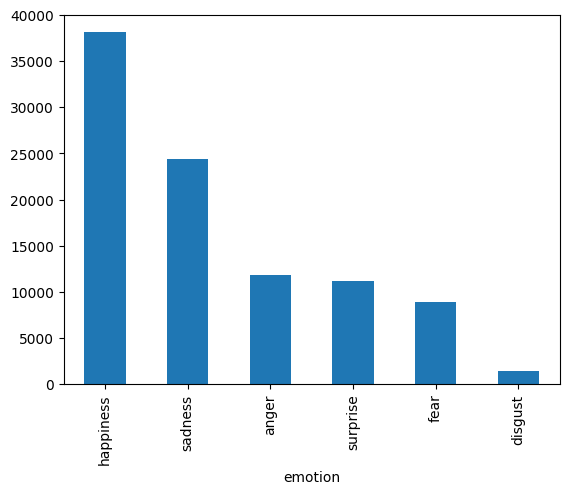

In [13]:
y_test.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

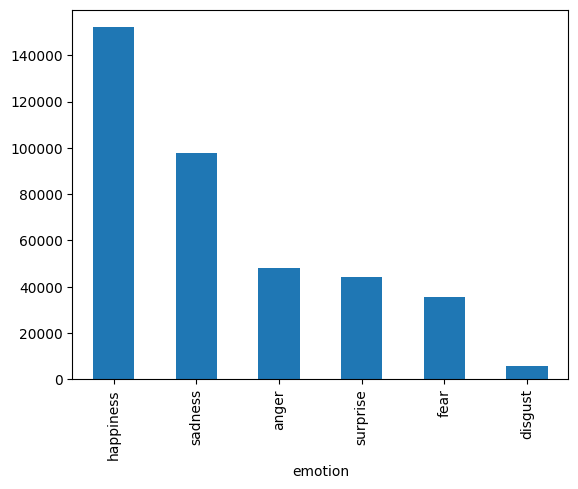

In [14]:
y_train.value_counts().plot(kind='bar')

## 2. Prepare input data

In [15]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [16]:
texts = [' '.join(clean_text(text)) for text in data.sentence]

In [17]:
texts_train = [' '.join(clean_text(text)) for text in X_train]

In [18]:
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [19]:
print(texts_test[74])

i made christmas cards and i feel pretty satisfied with them


In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 80547


In [50]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,    28,   367,  5102],
       [    0,     0,     0, ...,  1073,    23,  3022],
       [    0,     0,     0, ...,  3058,  1087, 24395],
       ...,
       [    0,     0,     0, ...,     9,    47,   562],
       [    0,     0,     0, ...,   285,     9,   974],
       [    0,     0,     0, ...,  1233,     7,   455]])

**Categorize** labels: 

In [52]:
encoding = {
    'happiness': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'surprise': 4,
    'disgust': 5
}

In [54]:
# Integer labels
y_train = [encoding[x] for x in df_train_cleaned.emotion]
y_test = [encoding[x] for x in df_test_cleaned.emotion]

In [55]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

In [56]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [58]:
import urllib.request
import zipfile
import os

fname = 'embeddings/crawl-300d-2M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip',
                              'crawl-300d-2M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('crawl-300d-2M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('crawl-300d-2M.vec.zip')

In [59]:
fname = 'embeddings/crawl-300d-2M.vec'

In [60]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(80548, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [61]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in crawl vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in crawl vocab: 64978
New words found: 15569


## Create CNN Pipeline

In [62]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [63]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [64]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          24164400  
                                                                 
 conv1d_2 (Conv1D)           (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24,462,390
Trainable params: 297,990
Non-trainable params: 24,164,400
____________________________________

##  Train the Model

In [66]:
X_train_pad.shape, y_train.shape

((383301, 500), (383301, 6))

In [67]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Stop training if validation loss doesn't improve for 3 epochs

In [68]:
batch_size = 512
epochs = 55

# Train the model with early stopping
hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad, y_test),
                 callbacks=[early_stopping])


Epoch 1/55
749/749 [==============================] - 75s 87ms/step - loss: 0.2392 - accuracy: 0.9184 - val_loss: 0.1509 - val_accuracy: 0.9476
Epoch 2/55
749/749 [==============================] - 62s 82ms/step - loss: 0.1250 - accuracy: 0.9563 - val_loss: 0.1409 - val_accuracy: 0.9509
Epoch 3/55
749/749 [==============================] - 62s 83ms/step - loss: 0.0998 - accuracy: 0.9650 - val_loss: 0.1432 - val_accuracy: 0.9509
Epoch 4/55
749/749 [==============================] - 63s 84ms/step - loss: 0.0801 - accuracy: 0.9716 - val_loss: 0.1411 - val_accuracy: 0.9534
Epoch 5/55
749/749 [==============================] - 63s 84ms/step - loss: 0.0640 - accuracy: 0.9774 - val_loss: 0.1537 - val_accuracy: 0.9537
Epoch 6/55
749/749 [==============================] - 60s 80ms/step - loss: 0.0519 - accuracy: 0.9813 - val_loss: 0.1703 - val_accuracy: 0.9520
Epoch 7/55
749/749 [==============================] - 61s 82ms/step - loss: 0.0426 - accuracy: 0.9849 - val_loss: 0.1856 - val_accuracy:

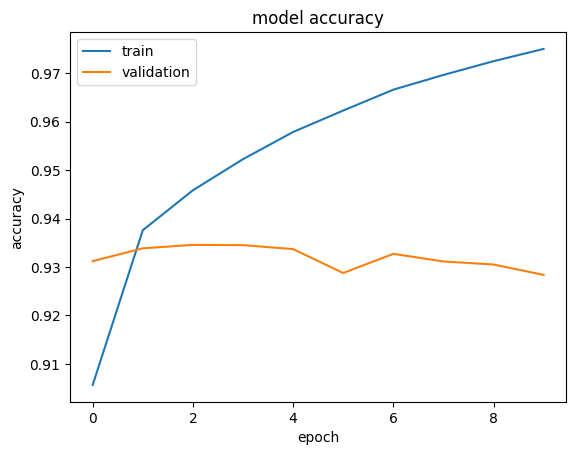

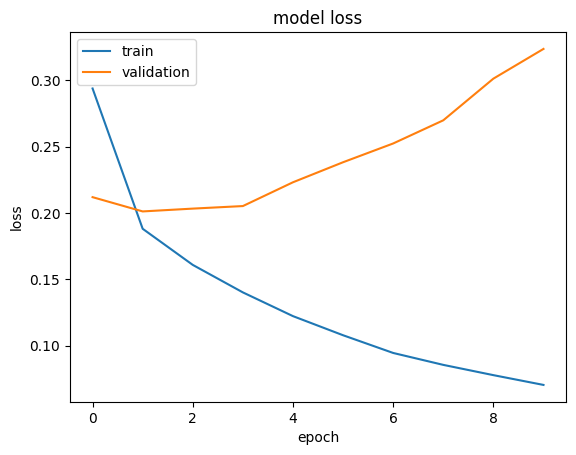

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##  Evaluation

In [69]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

2995/2995 [==============================] - 13s 4ms/step


In [70]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test_cleaned.emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

Accuracy: 95.09%

F1 Score: 95.09


#### Plotting confusion Matrix:

In [71]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 95.09


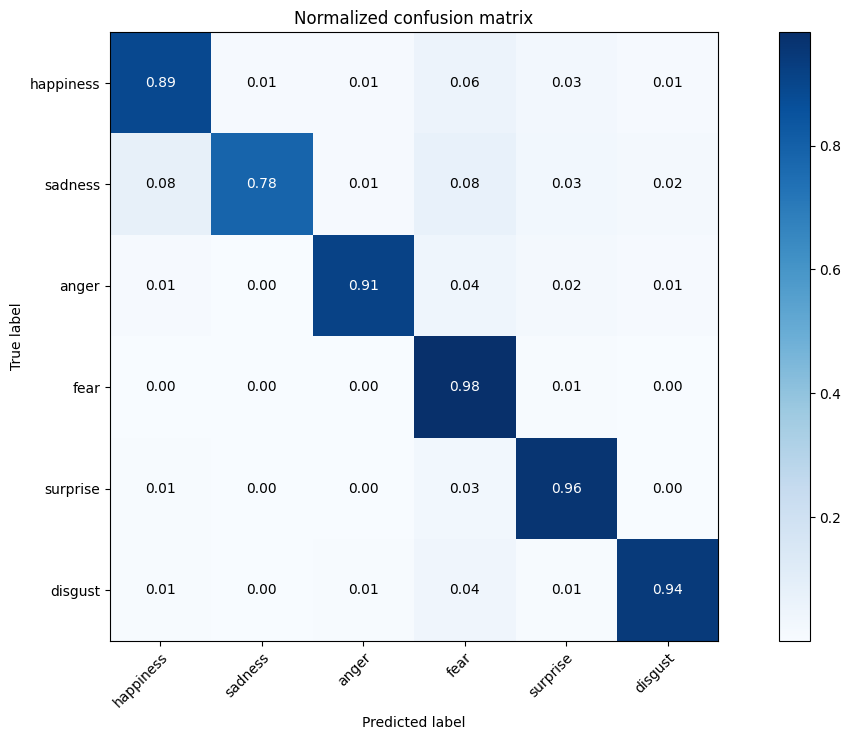

In [72]:
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_test_cleaned.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [73]:
import time

message = ['I am so sad at you!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 80ms/step
Message: ['I am so sad at you!']
predicted: sadness (0.13 seconds)


In [74]:
kaggle_data = pd.read_csv('raw_data/kaggle_data.csv', sep='\t')
kaggle_data

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."
...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...
1432,1432,Her ability to recall obscure facts never ceas...
1433,1433,"Your cat is so cute, I love him."
1434,1434,She remained skeptical about the new product.


In [75]:
# Function to predict emotion for a given sentence
def predict_emotion(sentence):
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_seq_len)
    pred = model.predict(padded, verbose = 0)
    return class_names[np.argmax(pred)]

In [76]:
# Apply predict_emotion function to each sentence in the DataFrame
kaggle_data['emotion'] = kaggle_data['sentence'].apply(predict_emotion)

In [77]:
kaggle_data.value_counts('emotion')

emotion
happiness    396
sadness      276
anger        231
fear         218
disgust      171
surprise     144
Name: count, dtype: int64

In [82]:
kaggle_data

,id,sentence,emotion
0,0,Girls are happy when they get flowers,happiness
1,1,His jaw dropped in disbelief when he saw the p...,surprise
2,2,Sometimes the ugly stench makes me wanna throw...,disgust
3,3,The foul odor from the garbage bin was disgust...,disgust
4,4,"I can’t believe it, they lost the game in the ...",sadness
...,...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...,sadness
1432,1432,Her ability to recall obscure facts never ceas...,surprise
1433,1433,"Your cat is so cute, I love him.",happiness
1434,1434,She remained skeptical about the new product.,fear


In [83]:
# Creating new dataframe without the sentence column:
kaggle_submission = kaggle_data.drop('sentence', axis=1)

In [84]:
kaggle_submission.to_csv('submission_6_CNN_NO_N.csv', index=False)

In [85]:
# creates a HDF5 file 'my_model.h5'
model.save('models/cnn_w2v_6_NO_N.h5')